El TARGET es el karma y los votos

- Predicción de los sentimientos en los comentarios publicados de Meneame , teniendo en cuenta el karma de la publicación y los votos recividos a la misma.

In [1]:

# Limpieza
import numpy as np
import pandas as pd
import nltk

# Graficas
import matplotlib.pyplot as plt
import seaborn as sns

# Normalizacion
from sklearn.preprocessing import MinMaxScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV

# Train, Test
from sklearn.model_selection import train_test_split

# Metricas
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Clasificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Validacion
from sklearn.model_selection import StratifiedKFold

In [2]:
df_completo = pd.read_csv("Data/100178_Comentarios.csv", sep=";")
df_completo.shape

(100178, 10)

In [3]:
df_completo.head()

,URL,fecha_envio,fecha_publicacion,pag_comentario,num_comentario,usuario,fecha,texto,votos,karma
0,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,1,ingenierodepalillos,1715371791,"O que les den de hostias hasta hartarse, son t...",8.0,77.0
1,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,2,Top_Banana,1715372035,"#1 Sea cual sea la opción, seguro que preferir...",3.0,35.0
2,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,3,Top_Banana,1715372235,"Un saludo Mysto, ¡hermoso!",4.0,51.0
3,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,4,CharlesBrowson,1715372556,Es tal es desproposito y la barbarie que no ca...,6.0,52.0
4,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,5,BigMom,1715372955,"#1 Es el problema, uno no quiere rebajarse. Pe...",3.0,33.0


In [4]:

df_completo.isna().sum()

URL                    0
fecha_envio            0
fecha_publicacion      0
pag_comentario         0
num_comentario         0
usuario                2
fecha                  0
texto                 33
votos                785
karma                785
dtype: int64

In [5]:
df_no_nan = df_completo.dropna()

In [6]:
df_no_nan.isna().sum()

URL                  0
fecha_envio          0
fecha_publicacion    0
pag_comentario       0
num_comentario       0
usuario              0
fecha                0
texto                0
votos                0
karma                0
dtype: int64

In [7]:
df_no_nan.shape

(99358, 10)

In [8]:
df_no_nan.head()

,URL,fecha_envio,fecha_publicacion,pag_comentario,num_comentario,usuario,fecha,texto,votos,karma
0,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,1,ingenierodepalillos,1715371791,"O que les den de hostias hasta hartarse, son t...",8.0,77.0
1,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,2,Top_Banana,1715372035,"#1 Sea cual sea la opción, seguro que preferir...",3.0,35.0
2,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,3,Top_Banana,1715372235,"Un saludo Mysto, ¡hermoso!",4.0,51.0
3,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,4,CharlesBrowson,1715372556,Es tal es desproposito y la barbarie que no ca...,6.0,52.0
4,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,5,BigMom,1715372955,"#1 Es el problema, uno no quiere rebajarse. Pe...",3.0,33.0


In [9]:
df_no_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99358 entries, 0 to 100177
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   URL                99358 non-null  object 
 1   fecha_envio        99358 non-null  int64  
 2   fecha_publicacion  99358 non-null  int64  
 3   pag_comentario     99358 non-null  int64  
 4   num_comentario     99358 non-null  int64  
 5   usuario            99358 non-null  object 
 6   fecha              99358 non-null  int64  
 7   texto              99358 non-null  object 
 8   votos              99358 non-null  float64
 9   karma              99358 non-null  float64
dtypes: float64(2), int64(5), object(3)
memory usage: 8.3+ MB


In [39]:
df_no_nan.shape

(99358, 10)

In [100]:
palabras_especificas = ["www.youtube.","»   ver comentario","»   comentario oculto por penalización","edit","www.",".com",".net",".org",".nl","mas.to","youtu.be","menea.me",".eu","jaja","jeje"]

mask = df_no_nan["texto"].str.contains("|".join(palabras_especificas), case=False)

df_filtrado_text = df_no_nan[~mask]

In [101]:
df_filtrado_text.shape

(63824, 10)

In [102]:
df_filtrado_text

,URL,fecha_envio,fecha_publicacion,pag_comentario,num_comentario,usuario,fecha,texto,votos,karma
0,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,1,ingenierodepalillos,1715371791,"O que les den de hostias hasta hartarse, son t...",8.0,77.0
1,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,2,Top_Banana,1715372035,"#1 Sea cual sea la opción, seguro que preferir...",3.0,35.0
2,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,3,Top_Banana,1715372235,"Un saludo Mysto, ¡hermoso!",4.0,51.0
3,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,4,CharlesBrowson,1715372556,Es tal es desproposito y la barbarie que no ca...,6.0,52.0
4,https://old.meneame.net/story/arresten-lideres...,1715371648,1715379303,1,5,BigMom,1715372955,"#1 Es el problema, uno no quiere rebajarse. Pe...",3.0,33.0
...,...,...,...,...,...,...,...,...,...,...
100169,https://old.meneame.net/story/comprar-coche-ca...,1712652664,1712654409,3,202,kovaliov7_6199a4fdcb40a,1712715302,#188 Yo era un chaval en los ochenta y no he c...,0.0,6.0
100171,https://old.meneame.net/story/comprar-coche-ca...,1712652664,1712654409,3,204,eduardor2k,1712732099,#189 porque en general los nuevos tardan x mes...,0.0,10.0
100172,https://old.meneame.net/story/comprar-coche-ca...,1712652664,1712654409,3,205,jacinto9999,1712737734,"Chavalito, te has metido en un bucle y tienes ...",0.0,6.0
100176,https://old.meneame.net/story/comprar-coche-ca...,1712652664,1712654409,3,209,fuemsa2004,1712741657,"#100 si el transporte publico funcionara, esto...",1.0,16.0


In [103]:
df_texto = df_filtrado_text["texto"]

df_texto

0         O que les den de hostias hasta hartarse, son t...
1         #1 Sea cual sea la opción, seguro que preferir...
2                                Un saludo Mysto, ¡hermoso!
3         Es tal es desproposito y la barbarie que no ca...
4         #1 Es el problema, uno no quiere rebajarse. Pe...
                                ...                        
100169    #188 Yo era un chaval en los ochenta y no he c...
100171    #189 porque en general los nuevos tardan x mes...
100172    Chavalito, te has metido en un bucle y tienes ...
100176    #100 si el transporte publico funcionara, esto...
100177    #164 Obviamente NO. el problema es que hay gen...
Name: texto, Length: 63824, dtype: object

In [104]:
df_texto.shape

(63824,)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300.]),
 [Text(-50.0, 0, '−50'),
  Text(0.0, 0, '0'),
  Text(50.0, 0, '50'),
  Text(100.0, 0, '100'),
  Text(150.0, 0, '150'),
  Text(200.0, 0, '200'),
  Text(250.0, 0, '250'),
  Text(300.0, 0, '300')])

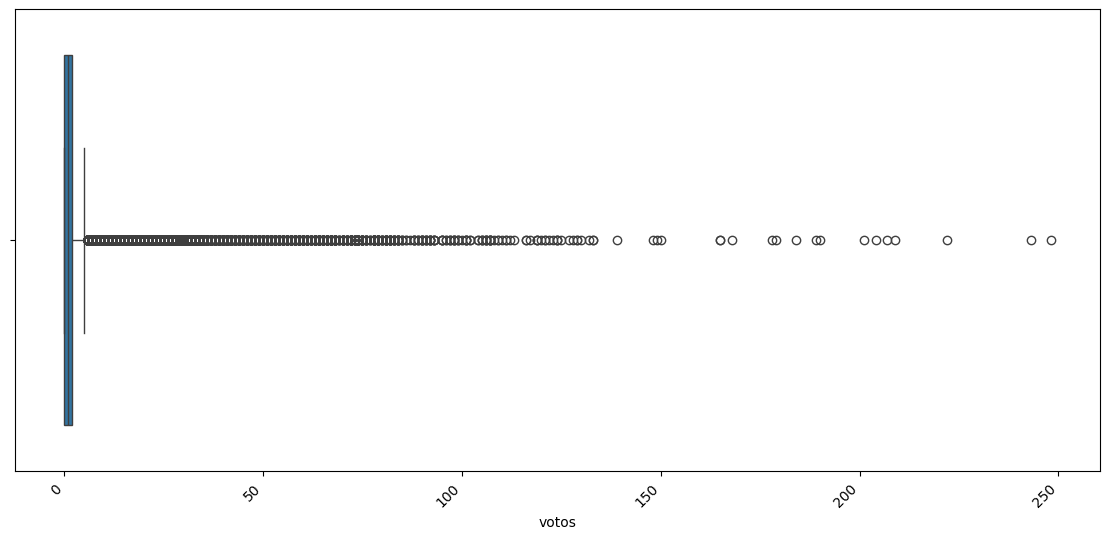

In [10]:
plt.figure(figsize = (14,6))
sns.boxplot(x=df_no_nan["votos"])
plt.xticks(rotation=45, ha="right")

(array([-1000.,  -500.,     0.,   500.,  1000.,  1500.,  2000.]),
 [Text(-1000.0, 0, '−1000'),
  Text(-500.0, 0, '−500'),
  Text(0.0, 0, '0'),
  Text(500.0, 0, '500'),
  Text(1000.0, 0, '1000'),
  Text(1500.0, 0, '1500'),
  Text(2000.0, 0, '2000')])

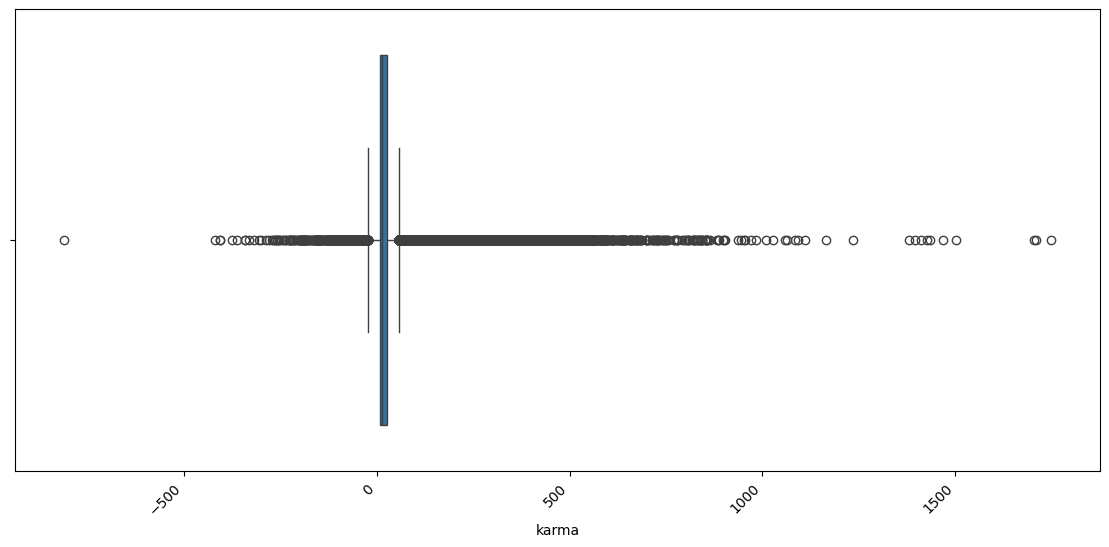

In [11]:
plt.figure(figsize = (14,6))
sns.boxplot(x=df_no_nan["karma"])
plt.xticks(rotation=45, ha="right")